In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tqdm
import logging
from typing import Tuple, Dict, Any, List, Union, Optional, Callable

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from metrics import calculate_metrics, metrics_to_tabular_string

random_state = 42

# logging levels: DEBUG, INFO, WARNING, ERROR, CRITICAL
# change to logging.WARNING to reduce verbosity
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

In [2]:
# Load the dataset
input_dir = "./kaggle/input/loan-approval-prediction-dataset/loan_approval_dataset.csv"
loan_original = pd.read_csv(input_dir)

loan_original.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [3]:
# columns have weird spaces in names:
loan_original.columns = loan_original.columns.str.replace(" ", "")
loan_original[loan_original["loan_id"].duplicated(keep=False) == True].sort_values(
    ["loan_id"]
)
# remove the loan_id column
loan_ds = loan_original.drop(["loan_id"], axis=1)

# replace all spaces in loan_status and education and self_employed columns to ""
loan_ds["loan_status"] = loan_ds["loan_status"].str.replace(" ", "")
loan_ds["education"] = loan_ds["education"].str.replace(" ", "")
loan_ds["self_employed"] = loan_ds["self_employed"].str.replace(" ", "")

GRADUATE_STRING = loan_ds["education"].unique()[0]
NOT_GRADUATE_STRING = loan_ds["education"].unique()[1]
# make education column binary
loan_ds["education"] = loan_ds["education"].apply(
    lambda x: 1 if x == GRADUATE_STRING else 0
)

APPROVED_STRING = loan_ds["loan_status"].unique()[0]
REJECTED_STRING = loan_ds["loan_status"].unique()[1]
# make loan_status column binary
loan_ds["loan_status"] = loan_ds["loan_status"].apply(
    lambda x: 1 if x == APPROVED_STRING else 0
)

YES_STRING = loan_ds["self_employed"].unique()[1]
NO_STRING = loan_ds["self_employed"].unique()[0]
# make self_employed column binary
loan_ds["self_employed"] = loan_ds["self_employed"].apply(
    lambda x: 1 if x == YES_STRING else 0
)

loan_ds.describe(include="all")

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
count,4269.000000,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03,4269.000000
mean,2.498712,0.502225,0.503631,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06,0.622160
std,1.695910,0.500054,0.500045,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06,0.484904
min,0.000000,0.000000,0.000000,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00,0.000000
25%,1.000000,0.000000,0.000000,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06,0.000000
50%,3.000000,1.000000,1.000000,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06,1.000000
75%,4.000000,1.000000,1.000000,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06,1.000000
max,5.000000,1.000000,1.000000,9.900000e+06,3.950000e+07,20.000000,900.000000,2.910000e+07,1.940000e+07,3.920000e+07,1.470000e+07,1.000000


In [4]:
# Basic parameters
default_batch_size = 64
default_test_size = 0.2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Splitting the dataset into features and target
X = loan_ds.drop("loan_status", axis=1).values
y = loan_ds["loan_status"].values

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=default_test_size, random_state=random_state
)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
class MLPModel(nn.Module):
    def __init__(self, input_size, layers_sizes):
        super(MLPModel, self).__init__()
        self.layers = nn.ModuleList()
        for i, layer_size in enumerate(layers_sizes):
            if i == 0:
                self.layers.append(nn.Linear(input_size, layer_size))
            else:
                self.layers.append(nn.Linear(layers_sizes[i - 1], layer_size))
            self.layers.append(nn.ReLU(inplace=True))
        self.layers.append(nn.Linear(layers_sizes[-1], 1))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return torch.sigmoid(x)


class Conv1DModel(nn.Module):
    def __init__(self, input_size, output_channels=16, kernel_size=3):
        super(Conv1DModel, self).__init__()
        self.conv1 = nn.Conv1d(1, output_channels, kernel_size=kernel_size, padding=1)
        self.fc1 = nn.Linear(
            output_channels * ((input_size + 2 * 1 - kernel_size) // 1 + 1), 64
        )
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        # Assuming x has shape (batch_size, input_size), we need to unsqueeze to (batch_size, 1, input_size) for Conv1D
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        # Flatten the output for the dense layer
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

In [6]:
# Helper functions to create a PyTorch dataset and dataloader
def prepare_data(
    loan_ds,
    test_size=default_test_size,
    random_state=random_state,
    batch_size=default_batch_size,
):
    # Splitting the dataset into features and target
    X = loan_ds.drop("loan_status", axis=1).values
    y = loan_ds["loan_status"].values

    # Splitting into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Standardizing the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Converting to PyTorch tensors
    X_torch_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_torch_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32)

    y_torch_train = torch.tensor(y_train, dtype=torch.float32)
    y_torch_test = torch.tensor(y_test, dtype=torch.float32)

    # Creating datasets and dataloaders
    train_dataset = TensorDataset(X_torch_train_scaled, y_torch_train)
    test_dataset = TensorDataset(X_torch_test_scaled, y_torch_test)

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False)

    return X_torch_train_scaled, X_torch_test_scaled, train_loader, test_loader


# Helper function that gets the names of the models and their corresponding PyTorch models


"""
This function generates some of the models we will work with.
MLP in different sizes, the layers sizes shown in the list.
And a conv1D model, which is like a convnet in 2D, but in 1D.
"""


def get_names_to_new_models(input_size):
    return {
        "Small MLP": MLPModel(input_size, [32, 16]),
        "Medium MLP": MLPModel(input_size, [64, 32, 16]),
        "Large MLP": MLPModel(input_size, [128, 64, 32, 16]),
        "Conv1D": Conv1DModel(input_size),  # Conv1D model
    }


# Helper function that trains and evaluates a PyTorch model


def train_and_evaluate_pytorch_model(
    threshold, model, model_name, train_loader, test_loader, epochs=100, lr=0.001
):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    # Training loop
    model.train()
    for epoch in tqdm.tqdm(range(epochs), desc=f"Training {model_name}"):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    all_labels = []
    all_outputs = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze()
            all_labels.extend(labels.numpy())
            all_outputs.extend(outputs.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_outputs = np.array(all_outputs)
    metrics = calculate_metrics(all_labels, all_outputs, threshold)

    return {
        "model": model,
        "model_name": model_name,
        "metrics": metrics,
    }


# Helper function that compares the results of different models
# According to the metrics given in metrics parameter
def compare_torch_models(model_results, metrics):
    model_metrics = {}
    model_names = {}
    for metric in metrics:
        model_metrics[metric] = [result["metrics"][metric]
                                 for result in model_results]
        model_names[metric] = [result["model_name"]
                               for result in model_results]

    # Plotting
    width = 0.35  # the width of the bars
    fig, ax = plt.subplots(len(metrics), 1, figsize=(14, 12))

    colors = ["orange", "blue", "green", "red"]

    for i, metric in enumerate(metrics):
        x = np.arange(len(model_names[metric]))  # the label locations
        rects = ax[i].bar(
            x, model_metrics[metric], width, label=metric, color=colors[i % len(
                colors)]
        )
        # Show the number on the bars
        for rect in rects:
            height = rect.get_height()
            ax[i].annotate(
                f"{height:.4f}",
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha="center",
                va="bottom",
            )
        ax[i].set_ylabel("Scores")
        ax[i].set_title(f"Model {metric} Comparison")
        ax[i].set_xticks(x)
        ax[i].set_xticklabels(model_names[metric])
        ax[i].legend()

    fig.tight_layout()
    plt.show()

# let's try to drop cols and see which important for classification


In [10]:
def copy_without_cols(df, cols):
    """Return a copy of the DataFrame without the specified columns."""
    copy = df.copy()
    return copy.drop(cols, axis=1)


# partial_loan_ds = copy_without_cols(loan_ds, ["cibil_score"]) # gets 0.56 acc
partial_loan_ds = copy_without_cols(
    loan_ds, ["no_of_dependents", "education", "self_employed", "income_annum"]
)  # gets 0.56 acc
partial_loan_ds = copy_without_cols(
    loan_ds,
    [
        # "no_of_dependents",
        # "education",
        # "self_employed",
        # "income_annum",
        # "loan_amount",
        # "loan_term",
        # "residential_assets_value",
        # "commercial_assets_value",
        # "luxury_assets_value",
        # "bank_asset_value",
    ],  # gets 0.95 acc, cause there is the cibil_score still
)
partial_loan_ds.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,1,0,9600000,29900000,12,778,2400000,17600000,22700000,8000000,1
1,0,0,1,4100000,12200000,8,417,2700000,2200000,8800000,3300000,0
2,3,1,0,9100000,29700000,20,506,7100000,4500000,33300000,12800000,0
3,3,1,0,8200000,30700000,8,467,18200000,3300000,23300000,7900000,0
4,5,0,1,9800000,24200000,20,382,12400000,8200000,29400000,5000000,0


In [11]:
X_torch_train_scaled, X_torch_test_scaled, train_loader, test_loader = prepare_data(
    partial_loan_ds
)
input_size = X_torch_train_scaled.shape[1]
names_to_models = get_names_to_new_models(input_size)
threshold = 0.5

torch_models_results = []
for model_name, model in names_to_models.items():
    if model_name != "Large MLP":
        continue
    model = model.to(device)
    result = train_and_evaluate_pytorch_model(
        threshold, model, model_name, train_loader, test_loader
    )
    torch_models_results.append(result)

Training Large MLP:   0%|          | 0/100 [00:00<?, ?it/s]

Training Large MLP: 100%|██████████| 100/100 [00:06<00:00, 15.92it/s]


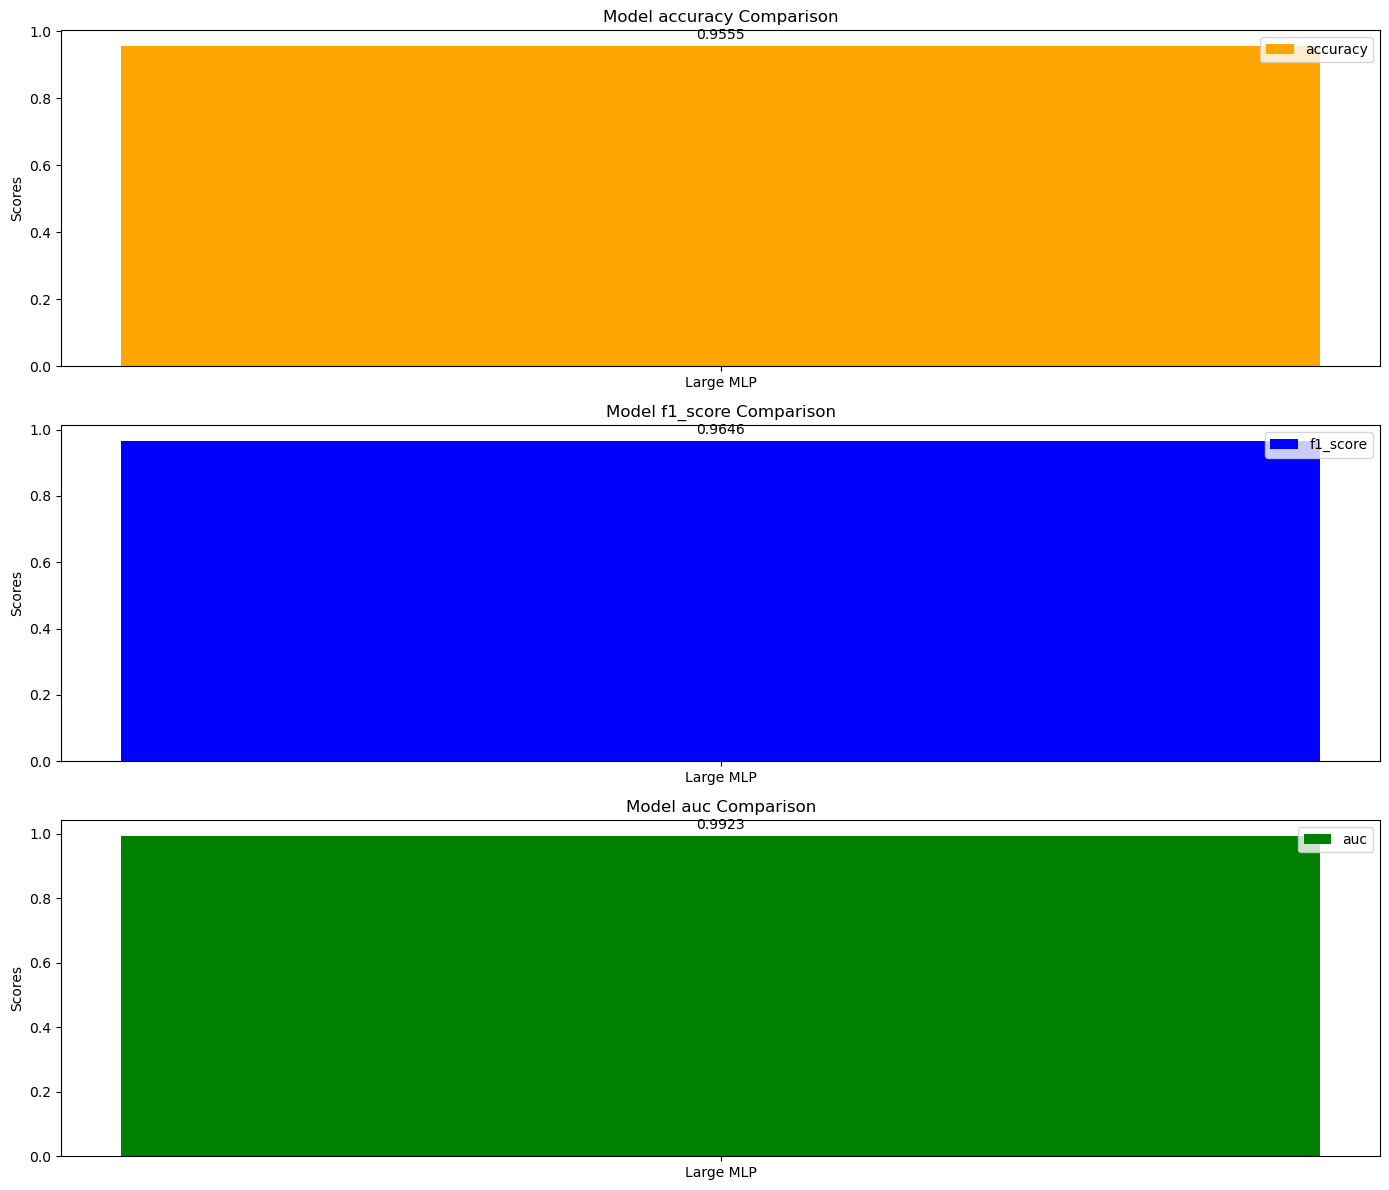

In [12]:
compare_torch_models(torch_models_results, ["accuracy", "f1_score", "auc"])